# [Time Series Forecasting](https://github.com/dmbee/seglearn/blob/master/examples/plot_forecast.py)

In this example, we use a feature representation pipeline to forecast a continuous time series target with a regressor. The algorithm is trained from the features and targets in the training set. Then predict (future segments) from the features in the test set. We do not sequentially retrain the algorithm as we move through the test set - which is an approach you will sometimes see with time series forecasting (and which may or may not be useful in your application).

**Author:** David Burns

**Modifications:** Alex Araujo

**License:** BSD

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from seglearn.pipe import Pype
from seglearn.split import temporal_split
from seglearn.transform import FeatureRep, SegmentXYForecast, last

%matplotlib inline

In [2]:
t = np.arange(5000) / 100
Y = np.sin(t) * t ** (1.15) * 2.5 + 1.5 * (t - 25) ** 2

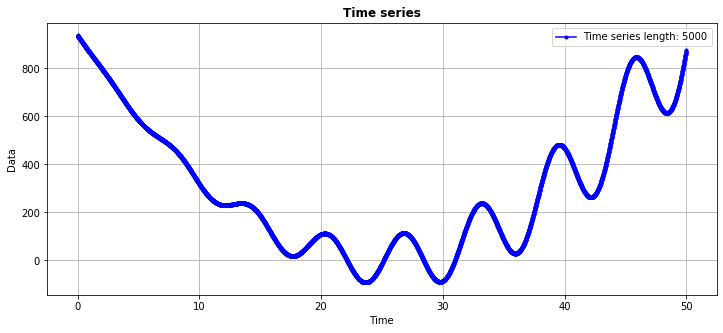

In [3]:
plt.figure(figsize=(12, 5))
plt.plot(t, Y, ".-b", label=f"Time series length: {Y.size}")
plt.xlabel("Time"); plt.ylabel("Data"); plt.title("Time series", weight="bold")
plt.legend()
plt.grid();

In [4]:
# With forecasting, X can include the target.
X = np.stack([t, Y], axis=1)

In [5]:
# Remember for a single time series, we need to make a list.
X = [X]
Y = [Y]

In [6]:
# Split the data along the time axis (our only option since we have only one time series).
X_train, X_test, y_train, y_test = temporal_split(X, Y, test_size=0.25)

In [7]:
# Split this single element list.
print(">>> X_train:\n", X_train[0])
print("\n>>> Shape:", X_train[0].shape)

>>> X_train:
 [[0.00000000e+00 9.37500000e+02]
 [1.00000000e-02 9.36750275e+02]
 [2.00000000e-02 9.36001156e+02]
 ...
 [3.74700000e+01 1.96614544e+02]
 [3.74800000e+01 1.98550839e+02]
 [3.74900000e+01 2.00491908e+02]]

>>> Shape: (3750, 2)


In [8]:
# Split this single element list.
print(">>> X_test:\n", X_test[0])
print("\n>>> Shape:", X_test[0].shape)

>>> X_test:
 [[ 37.5        202.43759554]
 [ 37.51       204.38774748]
 [ 37.52       206.34220793]
 ...
 [ 49.97       869.84057908]
 [ 49.98       872.72739529]
 [ 49.99       875.62183038]]

>>> Shape: (1250, 2)


In [9]:
# Create a feature representation pipeline.
# Setting y_func=last, and forecast=200 makes us predict the value of y 200 samples ahead of 
# the segment. Other reasonable options for y_func are mean, all (or create your own 
# function). See the API documentation for further details.
clf = Pype([("segment", SegmentXYForecast(width=400, 
                                          overlap=0.95,
                                          y_func=last, 
                                          forecast=5)),
            ("features", FeatureRep()),
            ("scale", RobustScaler()),
            ("lin", LinearRegression())])

In [10]:
# Nonlinear regression.
clf2 = Pype([("segment", SegmentXYForecast(width=400, 
                                           overlap=0.95, 
                                           y_func=last, 
                                           forecast=5)),
             ("features", FeatureRep()),
             ("scale", RobustScaler()),
             ("nonlin", MLPRegressor(hidden_layer_sizes=(100),
                                     activation="relu",
                                     solver="sgd",
                                     batch_size="auto",
                                     learning_rate="adaptive",
                                     learning_rate_init=0.00005,
                                     verbose=False))])

In [11]:
# Let's see the sliding window partitions for train and test sets.
X_train_sw, y_train_sw, _ = clf.get_params()["segment"].fit_transform(X_train, y_train)
X_test_sw, y_test_sw, _ = clf.get_params()["segment"].fit_transform(X_test, y_test)

In [12]:
print(">>> Sliding window size:", clf["segment"].width)
print(">>> Sliding window overlap:", clf["segment"].overlap * 100, "%")
print("\n>>> Train:")
print("* X sliding window shape:", X_train_sw.shape)
print("* Y sliding window shape:", y_train_sw.shape)
print("\n>>> Test:")
print("* X sliding window shape:", X_test_sw.shape)
print("* Y sliding window shape:", y_test_sw.shape)

>>> Sliding window size: 400
>>> Sliding window overlap: 95.0 %

>>> Train:
* X sliding window shape: (168, 400, 2)
* Y sliding window shape: (168,)

>>> Test:
* X sliding window shape: (43, 400, 2)
* Y sliding window shape: (43,)


In [13]:
# Fit and score (linear).
clf.fit(X_train, y_train);
clf.score(X_test, y_test);

In [14]:
print("N series in train: ", len(X_train))
print("N series in test: ", len(X_test))
print("N segments in train: ", clf.N_train)
print("N segments in test: ", clf.N_test)
print("Score (train): ", clf.score(X_train, y_train))
print("Score (test): ", clf.score(X_test, y_test))

N series in train:  1
N series in test:  1
N segments in train:  168
N segments in test:  43
Score (train):  0.9550793720785504
Score (test):  -3.0653965075556515


In [15]:
# Fit and score (nonlinear).
clf2.fit(X_train, y_train)
clf2.score(X_test, y_test);

/home/alex/anaconda3/envs/machine36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Score (train):  0.940877071343792
Score (test):  0.37813178051614205


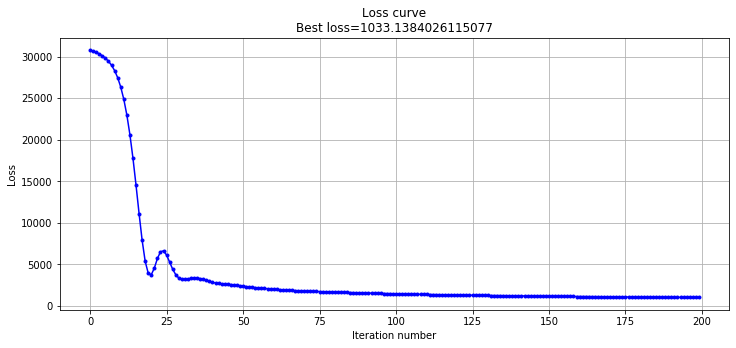

In [16]:
print("\nScore (train): ", clf2.score(X_train, y_train))
print("Score (test): ", clf2.score(X_test, y_test))

plt.figure(figsize=(12, 5))
plt.plot(clf2["nonlin"].loss_curve_, ".-b")
plt.title(f"Loss curve\nBest loss={clf2['nonlin'].best_loss_}")
plt.xlabel("Iteration number")
plt.ylabel("Loss")
plt.grid();

In [17]:
# Generate some predictions.

# Linear.
y, y_p = clf.transform_predict(X, Y)                 # All predictions.
ytr, ytr_p = clf.transform_predict(X_train, y_train) # Training predictions.
yte, yte_p = clf.transform_predict(X_test, y_test)   # Test predictions.

# Nonlinear.
_, yte_p2 = clf2.transform_predict(X_test, y_test)   

In [18]:
# Note: the first few segments in the test set won't have predictions (gap).
# We plot the gap for the visualization to hopefully make the situation clear.
Ns = len(y)
ts = np.arange(Ns)  # Segment number.
ttr = ts[0: len(ytr)]
tte = ts[(Ns - len(yte)):Ns]
tga = ts[len(ytr):(Ns - len(yte))]
yga = y[len(ytr):(Ns - len(yte))]

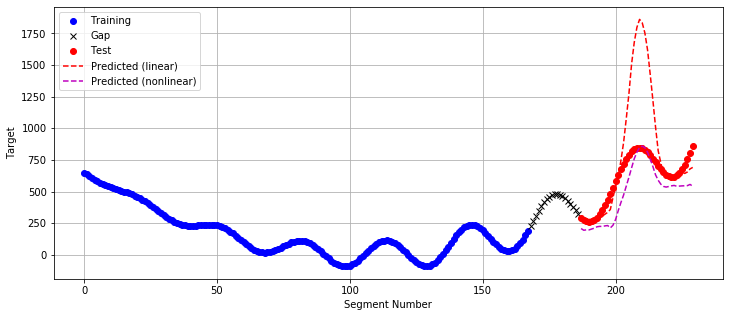

In [19]:
# Plot the results.
plt.figure(figsize=(12, 5))
plt.plot(ttr, ytr, "ob", label="Training")
plt.plot(tga, yga, "xk", label="Gap")
plt.plot(tte, yte, "or", label="Test")
plt.plot(tte, yte_p, "--r", label="Predicted (linear)")
plt.plot(tte, yte_p2, "--m", label="Predicted (nonlinear)")

plt.xlabel("Segment Number")
plt.ylabel("Target")
plt.legend()
plt.grid();